[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ELTE-DSED/Intro-Data-Security/blob/main/module_02_input_manipulation/Lab2_Evasion_Attacks.ipynb)

# **Lab 2: Evasion Attacks (Adversarial Examples)**

**Course:** Introduction to Data Security Pr.  
**Module 2:** Input Data Manipulation  
**Estimated Time:** 90-120 minutes

---

In this lab, we explore how adversaries can manipulate input data to deceive machine learning models. Adversarial examples are carefully crafted inputs that appear normal to humans but cause models to make incorrect predictions with high confidence. These attacks highlight vulnerabilities in even state-of-the-art neural networks and motivate the need for robust defenses.

<div align="center">
  <img src="images/openai_panda.png" alt="Adversarial Example: Panda to Gibbon">
</div>

## **Learning Objectives**

By the end of this lab, you will be able to:
- Generate adversarial examples using FGSM and PGD
- Measure model robustness under $\ell_\infty$ perturbations
- Visualize perturbations and their impact on predictions
- Compare clean vs. adversarial accuracy
- Discuss the robustness–accuracy tradeoff

## **Table of Contents**
1. [Setup & Imports](#setup)  
2. [Load Model & Dataset](#data)  
3. [Baseline Evaluation](#baseline)  
4. [FGSM Attack](#fgsm)  
5. [PGD Attack ($\ell_\infty$ and $\ell_2$)](#pgd)  
6. [Targeted Evasion Attacks](#targeted)  
7. [Adversarial Training (Defense)](#defense)  
8. [Library Implementation (secml-torch)](#library)  
9. [Exercises](#exercises)

## **1. Setup & Imports** <a name="setup"></a>

In [1]:
# If needed, install dependencies
%pip install secml-torch -q

# Enable automatic reloading of external modules
%load_ext autoreload
%autoreload 2

# Importing all the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import test_untargeted_attack, test_targeted_attack

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Note: you may need to restart the kernel to use updated packages.
Using device: cpu


## **2. Load Model & Dataset** <a name="data"></a>

We will train MNIST model.

In [2]:
# Load MNIST test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Optional train set for fallback training
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define the MLP model from Lab 1
class MNISTNet(torch.nn.Module):
    """Simple fully connected network for MNIST classification."""

    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 200)
        self.fc2 = torch.nn.Linear(200, 200)
        self.fc3 = torch.nn.Linear(200, 10)

    def forward(self, x):
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

net = MNISTNet().to(device)

net.eval()

# Normalized clamp bounds for MNIST
mnist_mean = 0.1307
mnist_std = 0.3081
min_val = (0.0 - mnist_mean) / mnist_std
max_val = (1.0 - mnist_mean) / mnist_std
print(f"Normalized clamp range: [{min_val:.2f}, {max_val:.2f}]")

Normalized clamp range: [-0.42, 2.82]


In [3]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Initialize the trainer for 1 epoch
trainer = BasePyTorchTrainer(optimizer=optimizer, epochs=1)

# Wrap the net and train
model = BasePytorchClassifier(model=net, trainer=trainer)
model.train(dataloader=train_loader)

# Evaluate accuracy
clean_accuracy = Accuracy()(model, test_loader)
print(f"Clean accuracy: {clean_accuracy * 100:.2f}%")

Clean accuracy: 95.98%


## **3. FGSM Attack** <a name="fgsm"></a>
### **3.1 Untargeted FGSM**

The Fast Gradient Sign Method (FGSM) proposed by [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf)  crafts adversarial examples by taking a single step in the direction of the input gradient.

The attack constructs adversarial examples as follows:

$$x_\text{adv} = x + \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   $x_\text{adv}$ : Adversarial image.
*   $x$ : Original input image.
*   $y$ : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

The current attack formulation is considered *untargeted* because it only seeks to maximize loss rather than to trick the model into predicting a specific label. 

Below is a complete implementation of the untargeted FGSM attack to understand how gradients from the model are used to perturb the input image.

In [4]:
def untargeted_fgsm(x_batch, true_labels, network, normalize, eps=8/255., **kwargs):
  """
  Generates a batch of untargeted FGSM adversarial examples.
  (Worked Example)
  """
  
  # 1. Clone input and enable gradient tracking
  x_batch = x_batch.clone().detach().requires_grad_(True)
  
  # 2. Normalize images for the network
  x_normalized = normalize(x_batch)
  
  # 3. Forward pass
  logits = network(x_normalized)
  
  # 4. Compute Loss
  loss_fn = nn.CrossEntropyLoss(reduction="mean")
  loss = loss_fn(logits, true_labels)
  
  # 5. Backward pass to get gradients
  network.zero_grad()
  loss.backward()
  
  # 6. Extract the sign of the gradient
  grad_sign = x_batch.grad.data.sign()
  
  # 7. Create adversarial images (FGSM formula: x + eps * sign(grad))
  x_adv = x_batch + eps * grad_sign
  
  # 8. Clamp back to valid pixel range [0, 1]
  x_adv = torch.clamp(x_adv, 0.0, 1.0)
  
  return x_adv.detach()

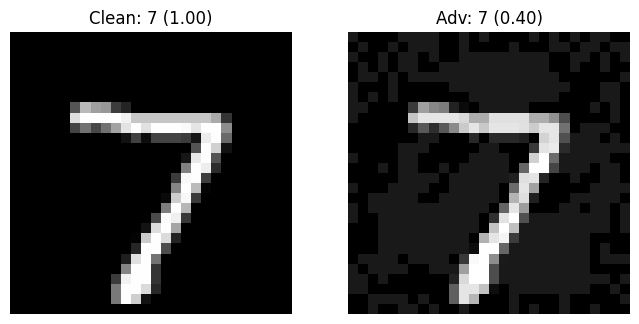

In [5]:
# Test the method
test_untargeted_attack(untargeted_fgsm, net, device, eps=0.1)

### **3.2 Targeted FGSM**

In addition to the untargeted FGSM which simply seeks to maximize loss, we can also create targeted adversarial attacks. We do this using the following equation:

$$x_{adv} = x - \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y_{target}))$$

where 

*   $x_{adv}$ : Adversarial image.
*   $x$ : Original input image.
*   $y_{target}$ : The target label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

Now it's your turn! Implement the `targeted_fgsm` function below. 

**Hint:** Instead of moving in a direction that *increases* the loss of the true label, you should move in a direction that *decreases* the loss of the **target label**.

In [6]:
def targeted_fgsm(x_batch, target_labels, network, normalize, eps=8/255., **kwargs):
  """
  Generates a batch of targeted FGSM adversarial examples.
  """
  # 1. Clone input and enable gradient tracking
  x_batch = x_batch.clone().detach().requires_grad_(True)

  # 2. Normalize images for the network
  x_normalized = normalize(x_batch)
  
  # 3. Forward pass
  logits = network(x_normalized)
  
  # 4. Compute Loss relative to target labels
  loss_fn = nn.CrossEntropyLoss(reduction="mean")
  loss = loss_fn(logits, target_labels)
  
  # 5. Backward pass
  network.zero_grad()
  loss.backward()
  
  # 6. Extract the sign of the gradient
  grad_sign = x_batch.grad.data.sign()
  
  # 7. Targeted update: SUBTRACT gradient sign to MINIMIZE loss of target
  x_adv = x_batch - eps * grad_sign
  
  # 8. Clamp back to valid pixel range [0, 1]
  x_adv = torch.clamp(x_adv, 0.0, 1.0)
  
  return x_adv.detach()

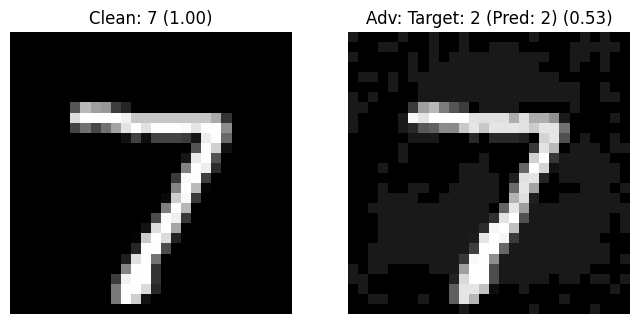

In [7]:
# Test your targeted implementation
test_targeted_attack(targeted_fgsm, net, device, target_label=2, eps=0.1)

## **4. PGD Attack ($\ell_\infty$ and $\ell_2$)** <a name="pgd"></a>

### **4.1 Untargeted PGD**

Projected Gradient Descent (PGD) by [Madry et al.](https://arxiv.org/pdf/1706.06083.pdf) iterates FGSM steps and projects back into the $\epsilon$-ball.

In [8]:
def untargeted_pgd(x_batch, true_labels, network, normalize, eps=0.3, alpha=0.01, steps=40, **kwargs):
    """
    Generates a batch of untargeted PGD adversarial examples.
    """
    x_batch = x_batch.clone().detach().to(device)
    true_labels = true_labels.to(device)
    
    # Initialize adversarial image with small noise
    x_adv = x_batch + 0.001 * torch.randn_like(x_batch)

    for _ in range(steps):
        x_adv.requires_grad_(True)
        
        # Normalize images for the network
        x_normalized = normalize(x_adv)
        
        # Forward pass
        logits = network(x_normalized)
        
        # Compute Loss
        loss_fn = nn.CrossEntropyLoss(reduction="mean")
        loss = loss_fn(logits, true_labels)
        
        # Backward pass
        network.zero_grad()
        loss.backward()
        
        # Extract the sign of the gradient
        grad_sign = x_adv.grad.data.sign()

        # Update adversarial image
        x_adv = x_adv + alpha * grad_sign
        
        # Project perturbation back into epsilon-ball
        perturbation = torch.clamp(x_adv - x_batch, min=-eps, max=eps)
        
        # Apply perturbation and clamp to valid pixel range [0, 1]
        x_adv = torch.clamp(x_batch + perturbation, 0.0, 1.0).detach()
        
    return x_adv

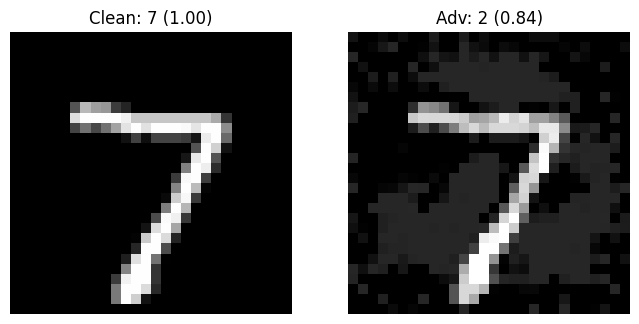

In [18]:
# Test the method
test_untargeted_attack(untargeted_pgd, net, device, eps=0.3, alpha=0.01, steps=15)

### **4.2 Targeted PGD**

Now implement the `targeted_pgd` function below.

**Hint:** Similar to targeted FGSM, you should move in a direction that *decreases* the loss of the **target label**. Remember to apply the step `alpha` instead of `eps` in each iteration, and project the total perturbation to the `eps`-ball.

In [12]:
def targeted_pgd(x_batch, target_labels, network, normalize, eps=0.3, alpha=0.01, steps=40, **kwargs):
    """
    Generates a batch of targeted PGD adversarial examples.
    """
    x_batch = x_batch.clone().detach().to(device)
    target_labels = target_labels.to(device)
    
    # Initialize adversarial image with small noise
    x_adv = x_batch + 0.001 * torch.randn_like(x_batch)

    for _ in range(steps):
        x_adv.requires_grad_(True)
        
        # Normalize images for the network
        x_normalized = normalize(x_adv)
        
        # Forward pass
        logits = network(x_normalized)
        
        # Compute Loss relative to target labels
        loss_fn = nn.CrossEntropyLoss(reduction="mean")
        loss = loss_fn(logits, target_labels)
        
        # Backward pass
        network.zero_grad()
        loss.backward()
        
        # Extract the sign of the gradient
        grad_sign = x_adv.grad.data.sign()

        # Targeted update: SUBTRACT gradient sign to MINIMIZE loss of target
        x_adv = x_adv - alpha * grad_sign
        
        # Project perturbation back into epsilon-ball
        perturbation = torch.clamp(x_adv - x_batch, min=-eps, max=eps)
        
        # Apply perturbation and clamp to valid pixel range [0, 1]
        x_adv = torch.clamp(x_batch + perturbation, 0.0, 1.0).detach()
        
    return x_adv

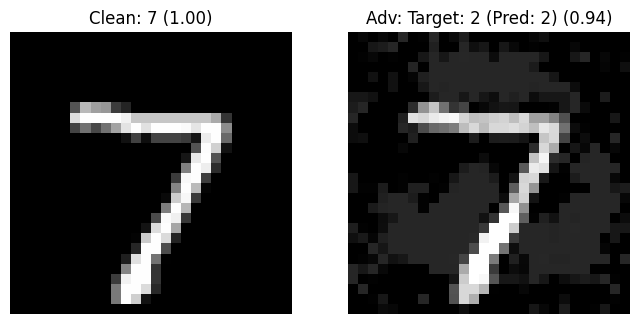

In [17]:
# Test your targeted implementation
test_targeted_attack(targeted_pgd, net, device, target_label=2, eps=0.3, alpha=0.01, steps=15)

### **4.3 $\ell_2$-Norm PGD Attack**

The standard PGD constrains perturbation to an $\ell_\infty$-ball constraint. Another common perturbation constraint is the $\ell_2$-norm, where the Euclidean distance between the original output and adversarial example is bounded by $\epsilon$.

Let's implement the helpers and an $\ell_2$ version of PGD manually:

In [22]:
def normalize_l2(x_batch):
    """Normalizes a batch of images by their L2 norm."""
    # L2 norm over dimensions 1, 2, 3 (C, H, W)
    norm = torch.norm(x_batch.view(x_batch.size(0), -1), p=2, dim=1, keepdim=True)
    norm = norm.unsqueeze(2).unsqueeze(3) # Reshape to match input for broadcasting
    # Avoid division by zero
    norm = torch.clamp(norm, min=1e-8)
    return x_batch / norm

def tensor_clamp_l2(x_batch, center, radius):
    """Batched clamp of x into l2 ball around center of given radius."""
    diff = x_batch - center
    diff_norm = torch.norm(diff.view(diff.size(0), -1), p=2, dim=1, keepdim=True)
    diff_norm = diff_norm.unsqueeze(2).unsqueeze(3)
    
    # Scale back if norm exceeds radius
    factor = torch.min(torch.ones_like(diff_norm), radius / (diff_norm + 1e-8))
    return center + diff * factor

def pgd_l2_attack(x_batch, true_labels, network, normalize, eps=3.0, alpha=0.5, steps=20, **kwargs):
    x_batch = x_batch.clone().detach().to(device)
    true_labels = true_labels.to(device)
    
    # Initialize adversarial image with small noise
    x_adv = x_batch.clone().detach() + 0.001 * torch.randn_like(x_batch)
    
    for _ in range(steps):
        x_adv.requires_grad = True
        x_normalized = normalize(x_adv)
        logits = network(x_normalized)
        loss = nn.CrossEntropyLoss()(logits, true_labels)
        network.zero_grad()
        loss.backward()
        
        # Take a step in the gradient direction, normalized by L2
        grad = normalize_l2(x_adv.grad)
        x_adv = x_adv + alpha * grad
        
        # Project (by clamping) the adversarial image back onto the L2 hypersphere
        x_adv = tensor_clamp_l2(x_adv, x_batch, eps)
        x_adv = torch.clamp(x_adv, min_val, max_val).detach()
        
    return x_adv

pgd_l2_acc = adversarial_accuracy(net, test_loader, pgd_l2_attack, eps=3.0, alpha=0.5, steps=20)
print(f"PGD L2 accuracy (eps=3.0): {pgd_l2_acc * 100:.2f}%")

PGD L2 accuracy (eps=3.0): 0.14%


### **4.4 Accuracy vs Number of PGD Steps**
Often, limiting the attacker to just a few steps prevents them from finding the optimal adversarial perturbation. As we increase the number of iteration steps, the attack becomes stronger, finding examples that reliably fool the model. Let's see how accuracy degrades as steps increase.

Running evaluation over multiple steps...
Steps=1 -> Accuracy: 94.21%
Steps=5 -> Accuracy: 78.04%
Steps=10 -> Accuracy: 29.68%
Steps=20 -> Accuracy: 0.58%
Steps=50 -> Accuracy: 0.00%


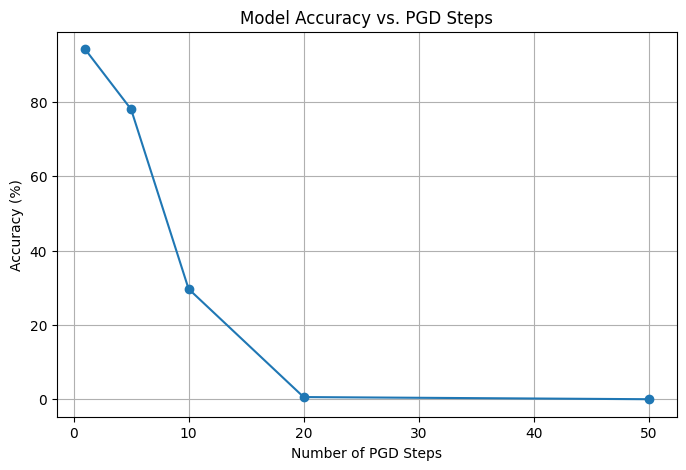

In [23]:
step_counts = [1, 5, 10, 20, 50]
accuracies = []

print("Running evaluation over multiple steps...")
for steps in step_counts:
    acc = adversarial_accuracy(net, test_loader, untargeted_pgd, eps=0.3, alpha=0.01, steps=steps)
    accuracies.append(acc)
    print(f"Steps={steps} -> Accuracy: {acc * 100:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(step_counts, [a * 100 for a in accuracies], marker='o')
plt.title("Model Accuracy vs. PGD Steps")
plt.xlabel("Number of PGD Steps")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

## **5. Adversarial Training (Defense) <a name="defense"></a>**

Adversarial training is one of the most effective and classical defenses against adversarial attacks. The concept is straightforward: generate adversarial examples during the training process and use them to augment the training dataset. Over time, the model learns to map these perturbed inputs to their correct labels, smoothing its decision boundaries.

Let's train a robust version of our model by including adversarial examples in the training loop. We will use the `secmlt` library's PGD attack during training.

In [24]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

# Define a robust net
robust_net = MNISTNet().to(device)
optimizer_robust = torch.optim.Adam(robust_net.parameters(), lr=0.001)

# PGD attack for generating adversarial examples during training
pgd_train = PGD(
    perturbation_model=LpPerturbationModels.LINF,
    epsilon=0.3,
    num_steps=7,
    step_size=0.1,
    random_start=True,
    lb=min_val,
    ub=max_val,
    backend=Backends.NATIVE
)

print("Starting Adversarial Training (1 epoch)...")
robust_net.train()

# Manual Adversarial Training Loop
for x_batch, y_batch in tqdm(train_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    # 1. Generate adversarial examples for the current batch
    # We create a temporary model for the current batch to satisfy secmlt's requirements
    tmp_model = BasePytorchClassifier(model=robust_net)
    batch_loader = DataLoader(TensorDataset(x_batch, y_batch), batch_size=x_batch.size(0))
    adv_loader = pgd_train(tmp_model, batch_loader)
    x_adv, _ = next(iter(adv_loader))
    
    # 2. Standard training step on the adversarial examples
    optimizer_robust.zero_grad()
    outputs = robust_net(x_adv.to(device))
    loss = nn.CrossEntropyLoss()(outputs, y_batch)
    loss.backward()
    optimizer_robust.step()

print("Robust training complete.")

# Evaluate this model's clean accuracy vs adversarial accuracy
robust_net.eval()
robust_model = BasePytorchClassifier(model=robust_net)

clean_acc_robust = Accuracy()(robust_model, test_loader)

# Use a strong 20-step PGD to test robustness
pgd_eval = PGD(
    perturbation_model=LpPerturbationModels.LINF,
    epsilon=0.3,
    num_steps=20,
    step_size=0.05,
    lb=min_val,
    ub=max_val,
    backend=Backends.NATIVE
)
adv_loader_robust = pgd_eval(robust_model, test_loader)
robust_acc_robust = Accuracy()(robust_model, adv_loader_robust)

print(f"\nRobust Model - Clean Accuracy: {clean_acc_robust * 100:.2f}%")
print(f"Robust Model - PGD Accuracy (eps=0.3): {robust_acc_robust * 100:.2f}%")

Starting Adversarial Training (1 epoch)...


100%|██████████| 469/469 [00:29<00:00, 16.17it/s]


Robust training complete.

Robust Model - Clean Accuracy: 95.99%
Robust Model - PGD Accuracy (eps=0.3): 83.10%


## **6. Library Implementation (secml-torch)** <a name="library"></a>

Now that we have implemented manual FGSM/PGD, we can replicate the same attacks using the `secml-torch` library for standardized evaluation and comparison.

Using a library like `secml-torch` simplifies research by providing standardized implementations of attacks and robust evaluation metrics.

### **6.1 Untargeted PGD with secml-torch**
We'll use the `PGD` class from `secml-torch`. Note that we must specify the `lb` (lower bound) and `ub` (upper bound) to match our normalized data range.

In [25]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.metrics.classification import Accuracy, AttackSuccessRate

# Wrap our net
model = BasePytorchClassifier(net)

# Define bounds based on MNIST normalization
# Reuse min_val and max_val computed earlier from mean/std

# Instantiate PGD
# To simulate FGSM, we can use num_steps=2
pgd_attack_secml = PGD(
    perturbation_model=LpPerturbationModels.LINF,
    epsilon=0.3,
    num_steps=10,
    step_size=0.05,
    random_start=False,
    backend=Backends.NATIVE,
    lb=min_val,
    ub=max_val
)

# Run attack on a small batch from our test_loader
adv_loader = pgd_attack_secml(model, test_loader)

# Evaluate Robust Accuracy
acc_metric = Accuracy()
robust_acc = acc_metric(model, adv_loader)
print(f"Robust Accuracy (PGD): {robust_acc.item() * 100:.2f}%")


Robust Accuracy (PGD): 34.56%


### **6.2 Targeted Attack and Attack Success Rate (ASR)**
The **Attack Success Rate (ASR)** measures the percentage of samples that the attacker successfully pushed to the target class.

In [26]:

y_target_val = 8
pgd_targeted = PGD(
    perturbation_model=LpPerturbationModels.LINF,
    epsilon=0.3,
    num_steps=15,
    step_size=0.05,
    y_target=y_target_val,
    backend=Backends.NATIVE,
    lb=min_val,
    ub=max_val
)

adv_loader_targeted = pgd_targeted(model, test_loader)

# Calculate ASR
asr_metric = AttackSuccessRate(y_target=y_target_val)
asr = asr_metric(model, adv_loader_targeted)
print(f"Attack Success Rate (Target: {y_target_val}): {asr.item() * 100:.2f}%")


Attack Success Rate (Target: 8): 35.55%


## **7. Exercises** <a name="exercises"></a>

1. Run FGSM with $\epsilon \in \{0.05, 0.1, 0.2, 0.3\}$ and plot accuracy vs. $\epsilon$.
2. Compare the perturbations visually between $\ell_\infty$ and $\ell_2$ attacks. You can display the difference array, e.g., `(x_adv - x).abs()`.
3. Train an adversarially robust model using **PGD** instead of FGSM for 1 epoch and evaluate its robustness. How does training time change?
4. Discuss why PGD is generally stronger than FGSM.